# Ecological Inference through Tsallis Regularized Optimal Transport (TROT)
This notebook presents the pipeline used in (cite our paper) to perform ecological inference on the Florida dataset.

You will first want to download the dataset from (url to the dataset)

In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from matplotlib.pylab import savefig

import sys
sys.path.append('..')
sys.path.append('../Trot')
sys.path.append('../Data')

from Trot import Distances as dist
from Trot.Evaluation import KL
from Trot.Florida_inference import CV_Local_Inference, Local_Inference

# Data Loading and Processing

In [2]:
FlData = pd.read_csv('../Fl_Data.csv', usecols = ['District', 'County','Voters_Age', 'Voters_Gender', 'PID', 'vote08', 
                    'SR.WHI', 'SR.BLA', 'SR.HIS', 'SR.ASI', 'SR.NAT', 'SR.OTH']) 

FlData = FlData.dropna()

Change gender values to numerical values

In [3]:
FlData['Voters_Gender'] = FlData['Voters_Gender'].map({'M': 1, 'F': 0})

Renormalize the age so that it takes values between 0 and 1

In [4]:
FlData['Voters_Age'] = ((FlData['Voters_Age'] -
                         FlData['Voters_Age'].min()) /
                        (FlData['Voters_Age'].max() -
                         FlData['Voters_Age'].min()))


One-hot party subscriptions (PID)

In [5]:
#Get one hot encoding of column PID
one_hot = pd.get_dummies(FlData['PID'])
# Drop column PID as it is now encoded
FlData = FlData.drop('PID', axis=1)
# Join the encoded df
FlData = FlData.join(one_hot)
# Rename the new columns
FlData.rename(columns={0: 'Other', 1: 'Democrat', 2: 'Republican'},
              inplace=True)

In [6]:
FlData.describe()

,District,County,Voters_Age,Voters_Gender,vote08,SR.WHI,SR.BLA,SR.HIS,SR.ASI,SR.NAT,SR.OTH,Other,Democrat,Republican
count,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06,9.235521e+06
mean,1.269016e+01,3.441942e+01,4.213903e-01,4.601492e-01,7.222461e-01,6.812650e-01,1.305151e-01,1.332630e-01,1.587241e-02,3.141891e-03,3.826249e-02,2.283238e-01,4.080179e-01,3.636583e-01
std,7.139123e+00,1.794370e+01,2.290823e-01,4.984094e-01,4.478914e-01,4.659861e-01,3.368693e-01,3.398587e-01,1.249819e-01,5.596445e-02,1.918293e-01,4.197524e-01,4.914665e-01,4.810519e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.000000e+00,1.600000e+01,2.375000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.300000e+01,3.900000e+01,4.250000e-01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.900000e+01,5.100000e+01,5.875000e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
max,2.500000e+01,6.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


# Compute Marginals and Joint Distributions

Create a county dictionnary

In [7]:
Voters_By_County = {}
all_counties = FlData.County.unique()
for county in all_counties:
    Voters_By_County[county] = FlData[FlData['County'] == county]

Compute the ground truth joint distribution

In [8]:
J = {}
for county in all_counties:
    J[county] = np.zeros((6, 3))

    J[county][0,0] = Voters_By_County[county].loc[(Voters_By_County[county]['Other'] ==1) & (Voters_By_County[county]['SR.WHI']==1)].shape[0]
    J[county][0,1] = Voters_By_County[county].loc[(Voters_By_County[county]['Democrat'] ==1) & (Voters_By_County[county]['SR.WHI']==1)].shape[0]
    J[county][0,2] = Voters_By_County[county].loc[(Voters_By_County[county]['Republican'] ==1) & (Voters_By_County[county]['SR.WHI']==1)].shape[0]

    J[county][1,0] = Voters_By_County[county].loc[(Voters_By_County[county]['Other'] ==1) & (Voters_By_County[county]['SR.BLA']==1)].shape[0]
    J[county][1,1] = Voters_By_County[county].loc[(Voters_By_County[county]['Democrat'] ==1) & (Voters_By_County[county]['SR.BLA']==1)].shape[0]
    J[county][1,2] = Voters_By_County[county].loc[(Voters_By_County[county]['Republican'] ==1) & (Voters_By_County[county]['SR.BLA']==1)].shape[0]

    J[county][2,0] = Voters_By_County[county].loc[(Voters_By_County[county]['Other'] ==1) & (Voters_By_County[county]['SR.HIS']==1)].shape[0]
    J[county][2,1] = Voters_By_County[county].loc[(Voters_By_County[county]['Democrat'] ==1) & (Voters_By_County[county]['SR.HIS']==1)].shape[0]
    J[county][2,2] = Voters_By_County[county].loc[(Voters_By_County[county]['Republican'] ==1) & (Voters_By_County[county]['SR.HIS']==1)].shape[0]

    J[county][3,0] = Voters_By_County[county].loc[(Voters_By_County[county]['Other'] ==1) & (Voters_By_County[county]['SR.ASI']==1)].shape[0]
    J[county][3,1] = Voters_By_County[county].loc[(Voters_By_County[county]['Democrat'] ==1) & (Voters_By_County[county]['SR.ASI']==1)].shape[0]
    J[county][3,2] = Voters_By_County[county].loc[(Voters_By_County[county]['Republican'] ==1) & (Voters_By_County[county]['SR.ASI']==1)].shape[0]

    J[county][4,0] = Voters_By_County[county].loc[(Voters_By_County[county]['Other'] ==1) &(Voters_By_County[county]['SR.NAT']==1)].shape[0]
    J[county][4,1] = Voters_By_County[county].loc[(Voters_By_County[county]['Democrat'] ==1) & (Voters_By_County[county]['SR.NAT']==1)].shape[0]
    J[county][4,2] = Voters_By_County[county].loc[(Voters_By_County[county]['Republican'] ==1) & (Voters_By_County[county]['SR.NAT']==1)].shape[0]

    J[county][5,0] = Voters_By_County[county].loc[(Voters_By_County[county]['Other'] ==1) & (Voters_By_County[county]['SR.OTH']==1)].shape[0]
    J[county][5,1] = Voters_By_County[county].loc[(Voters_By_County[county]['Democrat'] ==1) & (Voters_By_County[county]['SR.OTH']==1)].shape[0]
    J[county][5,2] = Voters_By_County[county].loc[(Voters_By_County[county]['Republican'] ==1) & (Voters_By_County[county]['SR.OTH']==1)].shape[0]

    J[county] /= J[county].sum()

In [9]:
print(J[12])

[[ 0.14002316  0.31636083  0.24990753]
 [ 0.01778736  0.14102832  0.00533942]
 [ 0.01595394  0.02251564  0.0117403 ]
 [ 0.01128194  0.01120957  0.00474437]
 [ 0.00099712  0.0018495   0.00104537]
 [ 0.01933933  0.02032037  0.00855594]]


Compute the party marginals

In [10]:
Party_Marginals = {}
parties = ['Other', 'Democrat', 'Republican']
for county in all_counties:
    Party_Marginals[county] = pd.Series([J[county][:, i].sum()
                                        for i in np.arange(3)])
    Party_Marginals[county].index = parties

Compute the ethnicity marginals

In [11]:
Ethnicity_Marginals = {}
ethnies = ['SR.WHI', 'SR.BLA', 'SR.HIS', 'SR.ASI', 'SR.NAT', 'SR.OTH']
for county in all_counties:
    Ethnicity_Marginals[county] = pd.Series([J[county][i, :].sum()
                                             for i in np.arange(6)])
    Ethnicity_Marginals[county].index = ethnies

# Compute the cost matrix
Using only age, gender, and 2008 vote or abstention

In [12]:
features = ['Voters_Age', 'Voters_Gender', 'vote08']
e_len, p_len = len(ethnies), len(parties)
M = np.zeros((e_len, p_len))
for i, e in enumerate(ethnies):
    data_e = FlData[FlData[e] == 1.0]
    average_by_e = data_e[features].mean(axis=0)
    for j, p in enumerate(parties):
        data_p = FlData[FlData[p] == 1.0]
        average_by_p = data_p[features].mean(axis=0)

        M[i, j] = np.array(dist.dist_2(average_by_e, average_by_p))

# Start the inference

Use a specific county or district to select the best parameters

In [13]:
CV_counties = FlData[FlData['District'] == 3].County.unique()
del FlData

Find the best parameters

In [14]:
q = np.arange(0.5, 3.1, 0.1)
l = [0.01, 0.1, 1., 10., 100.] 

best_score, best_q, best_l = CV_Local_Inference(Voters_By_County, M, J, Ethnicity_Marginals, Party_Marginals,
                   CV_counties,q,l)

q: 0.50, lambda: 0.0100, KL: 0.1071, STD: 0.05664
q: 0.50, lambda: 0.1000, KL: 0.1059, STD: 0.05582
q: 0.50, lambda: 1.0000, KL: 0.09552, STD: 0.04817
q: 0.50, lambda: 10.0000, KL: 0.09582, STD: 0.02227
q: 0.50, lambda: 100.0000, KL: 0.3353, STD: 0.04494
q: 0.60, lambda: 0.0100, KL: 0.1059, STD: 0.05514
q: 0.60, lambda: 0.1000, KL: 0.1046, STD: 0.05431
q: 0.60, lambda: 1.0000, KL: 0.09296, STD: 0.04666
q: 0.60, lambda: 10.0000, KL: 0.1031, STD: 0.02173
q: 0.60, lambda: 100.0000, KL: 0.3514, STD: 0.04774
q: 0.70, lambda: 0.0100, KL: 0.105, STD: 0.0536
q: 0.70, lambda: 0.1000, KL: 0.1035, STD: 0.05277
q: 0.70, lambda: 1.0000, KL: 0.08997, STD: 0.04502
q: 0.70, lambda: 10.0000, KL: 0.1164, STD: 0.02283
q: 0.70, lambda: 100.0000, KL: 0.3659, STD: 0.05176
q: 0.80, lambda: 0.0100, KL: 0.1045, STD: 0.05209
q: 0.80, lambda: 0.1000, KL: 0.1026, STD: 0.05125
q: 0.80, lambda: 1.0000, KL: 0.08665, STD: 0.04338
q: 0.80, lambda: 10.0000, KL: 0.1372, STD: 0.02595
q: 0.80, lambda: 100.0000, KL: 0.3761

Use selected parameters on the rest of the dataset

In [15]:
J_inferred = Local_Inference(Voters_By_County, M, J, Ethnicity_Marginals, Party_Marginals, all_counties, best_q, best_l)
kl, std = KL(J, J_inferred, all_counties, save_to_file=False, compute_abs_err=True)

Absolute error 0.00887520979305  +  0.00471122282927


# Plot the results

In [16]:
diag = np.linspace(-0.1, 1.0, 100)

# pickle results
f = open('../Data/joints_gallup.pkl', 'rb')
J_true, J = pickle.load(f)

f = open('../Data/baseline.pkl', 'rb')
J_baseline = pickle.load(f)

j_true, j, j_baseline = [], [], []
for c in all_counties:
    j_true.append(np.array(J_true[c]).flatten())
    j.append(np.array(J_inferred[c]).flatten())
    j_baseline.append(np.array(J_baseline[c]).flatten())

j_true = np.array(j_true).flatten()
j = np.array(j).flatten()
j_baseline = np.array(j_baseline).flatten()

Plot the correlation between the ground truth for the joint distribution and the infered distribution (the closer to the $x = y$ diagonal axis, the better

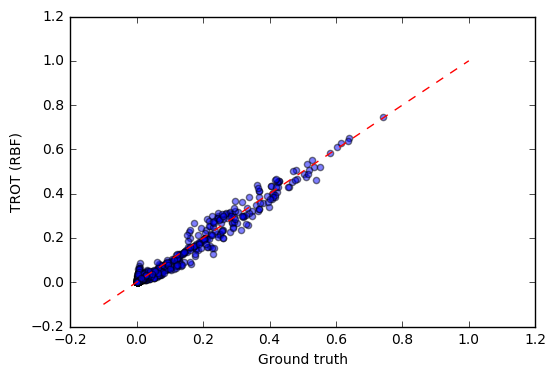

In [17]:
plt.figure()
plt.scatter(j_true, j, alpha=0.5)
plt.xlabel('Ground truth')
plt.ylabel('TROT (RBF)')
plt.plot(diag, diag, 'r--')

plt.show()

Plot the distribution of the error (the more packed around the origin of the $x$-axis, the better)

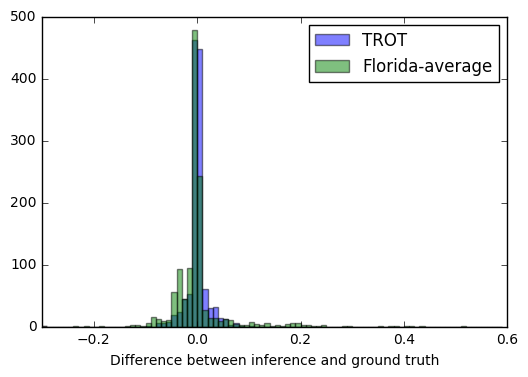

In [18]:
plt.figure()
bins = np.arange(-.3, .6, 0.01)
plt.hist(j_true - j, bins=bins, alpha=0.5, label='TROT')
plt.hist(j_true - j_baseline, bins=bins, alpha=0.5, label='Florida-average')
plt.legend()
plt.xlabel('Difference between inference and ground truth')

plt.show()

# Survey-based ecological inference
Same pipeline, but using a cost matrix computed thanks to the 2013 Gallup survey. (http://www.gallup.com/poll/160373/democrats-racially-diverse-republicans-mostly-white.aspx)

We assume that Gallup's Other = {Native, Other}

The cost matrix M is computed as $1-p_{ij}$, where $p_{ij}$ is the proportion of people registered to party $j$ belonging to group $i$.

In [19]:
M_sur = np.array([
               [.38, .26, .35],
               [.29, .64, .05],
               [.50, .32, .13],
               [.46, .36, .17],
               [.49, .32, .18],
               [.49, .32, .18]
               ])
M_sur = (1. - M_sur)

Once again, find the best parameters

In [20]:
best_score, best_q, best_l = CV_Local_Inference(Voters_By_County, M_sur, J, Ethnicity_Marginals, Party_Marginals,
                   CV_counties,q,l)

q: 0.50, lambda: 0.0100, KL: 0.1097, STD: 0.04583
q: 0.50, lambda: 0.1000, KL: 0.1075, STD: 0.04441
q: 0.50, lambda: 1.0000, KL: 0.0864, STD: 0.03165
q: 0.50, lambda: 10.0000, KL: 0.004734, STD: 0.002929
q: 0.50, lambda: 100.0000, KL: 0.07191, STD: 0.04125
q: 0.60, lambda: 0.0100, KL: 0.1079, STD: 0.04319
q: 0.60, lambda: 0.1000, KL: 0.1055, STD: 0.04176
q: 0.60, lambda: 1.0000, KL: 0.08241, STD: 0.02893
q: 0.60, lambda: 10.0000, KL: 0.002511, STD: 0.00117
q: 0.60, lambda: 100.0000, KL: 0.08426, STD: 0.04423
q: 0.70, lambda: 0.0100, KL: 0.1062, STD: 0.04035
q: 0.70, lambda: 0.1000, KL: 0.1035, STD: 0.0389
q: 0.70, lambda: 1.0000, KL: 0.07761, STD: 0.02592
q: 0.70, lambda: 10.0000, KL: 0.00247, STD: 0.002285
q: 0.70, lambda: 100.0000, KL: 0.09857, STD: 0.04825
q: 0.80, lambda: 0.0100, KL: 0.1049, STD: 0.03737
q: 0.80, lambda: 0.1000, KL: 0.1017, STD: 0.0359
q: 0.80, lambda: 1.0000, KL: 0.07217, STD: 0.0229
q: 0.80, lambda: 10.0000, KL: 0.006265, STD: 0.005058
q: 0.80, lambda: 100.0000, 

Using these parameters, run the inference on the rest of the dataset

In [ ]:
J_sur = Local_Inference(Voters_By_County, M_sur, J, Ethnicity_Marginals, Party_Marginals, all_counties, best_q, best_l)
kl, std = KL(J, J_sur, all_counties, save_to_file=False, compute_abs_err=True)

Plot correlation with ground truth

In [ ]:
j_sur = []
for c in all_counties:
    j_sur.append(np.array(J_sur[c]).flatten())

j_sur = np.array(j_sur).flatten()

plt.figure()
plt.scatter(j_true, j_sur, alpha=0.5)
plt.xlabel('Ground truth')
plt.ylabel('TROT (survey)')
plt.plot(diag, diag, 'r--')

plt.show()
    

Plot error distribution (compared with Florida average)

In [ ]:
plt.figure()
bins = np.arange(-.3, .6, 0.01)
plt.hist(j_true - j_sur, bins=bins, alpha=0.5, label='TROT (survey)')
plt.hist(j_true - j_baseline, bins=bins, alpha=0.5, label='Florida-average')
plt.legend()
plt.xlabel('Difference between inference and ground truth')

plt.show()